# Analysis of SDA networks

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from mesa.batchrunner import BatchRunner
from joblib import Parallel, delayed


In [13]:
#from model import ConsumatModel
from model_sda_newdata import ConsumatModel

In [14]:
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}


# Configuration for SDA networks with different homophily attributes
sda_conformity_config = base_config.copy()
sda_conformity_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 3,
        'b': 0.1,
        'homophily_attribute': 'preference_conformity'
    }
})

sda_sustainability_config = base_config.copy()
sda_sustainability_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 3,
        'b': 0.1,
        'homophily_attribute': 'preference_sustainability'
    }
})

sda_financial_config = base_config.copy()
sda_financial_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 3,
        'b': 0.1,
        'homophily_attribute': 'weight_financial'
    }
})

sda_social_config = base_config.copy()
sda_social_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 3,
        'b': 0.1,
        'homophily_attribute': 'weight_social'
    }
})

sda_personal_config = base_config.copy()
sda_personal_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 3,
        'b': 0.1,
        'homophily_attribute': 'weight_personal'
    }
})


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os

def run_simulation(model, num_steps):
    adoption_rates = []

    for _ in range(num_steps):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data

def run_single_simulation(config, num_steps):
    model = ConsumatModel(config)
    return run_simulation(model, num_steps)

def run_config_simulations(config_name, config, num_steps, num_simulations, pbar):
    all_simulation_data = []

    results = Parallel(n_jobs=-1)(
        delayed(run_single_simulation)(config, num_steps) for _ in range(num_simulations)
    )

    for result in results:
        model_data, agent_data = result
        all_simulation_data.append(model_data)
        pbar.update(1)
    
    aggregated_data = pd.concat(all_simulation_data).groupby(level=0).mean()
    
    return config_name, aggregated_data, all_simulation_data

def run_all_simulations(configurations, num_steps, num_simulations):
    results = {}
    total_simulations = len(configurations) * num_simulations
    
    with tqdm(total=total_simulations, desc="Overall Progress") as pbar:
        for config_name, config in configurations.items():
            config_name, aggregated_data, all_simulation_data = run_config_simulations(config_name, config, num_steps, num_simulations, pbar)
            results[config_name] = aggregated_data
            
            # Save results to CSV
            aggregated_data.to_csv(f'{config_name}_aggregated_data.csv')
            for i, sim_data in enumerate(all_simulation_data):
                sim_data.to_csv(f'{config_name}_simulation_{i+1}.csv')

            plt.figure(figsize=(10, 6))
            for sim_data in all_simulation_data:
                plt.plot(sim_data['Adoption Rates'], alpha=0.3)
            plt.plot(aggregated_data['Adoption Rates'], marker='o', color='b', label='Average')
            plt.title(f'True Price Adoption Rate Over Iterations for {config_name}')
            plt.xlabel('Iteration')
            plt.ylabel('True Price Adoption Rate (%)')
            plt.ylim(0,100)
            plt.grid(True)
            plt.legend()
            plt.show()

            plt.figure(figsize=(10, 5))
            if 'Average Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Degree'], label='Average Degree')
            if 'Variance of Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Variance of Degree'], label='Variance of Degree')
            if 'Average Clustering' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Clustering'], label='Average Clustering')
            if 'Average Path Length' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Path Length'], label='Average Path Length', linestyle='--')
            plt.xlabel('Step')
            plt.ylabel('Metric Value')
            plt.title(f'Network Metrics Over Time for {config_name}')
            plt.legend()
            plt.show()

    return results

def generate_decision_modes_count(agent_data):
    decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
    return decision_modes_count

network_configurations = {
    'SDA Preference Conformity': sda_conformity_config,
    'SDA Preference Sustainability': sda_sustainability_config,
    'SDA Weight Financial': sda_financial_config,
    'SDA Weight Social': sda_social_config,
    'SDA Weight Personal': sda_personal_config
}




Overall Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

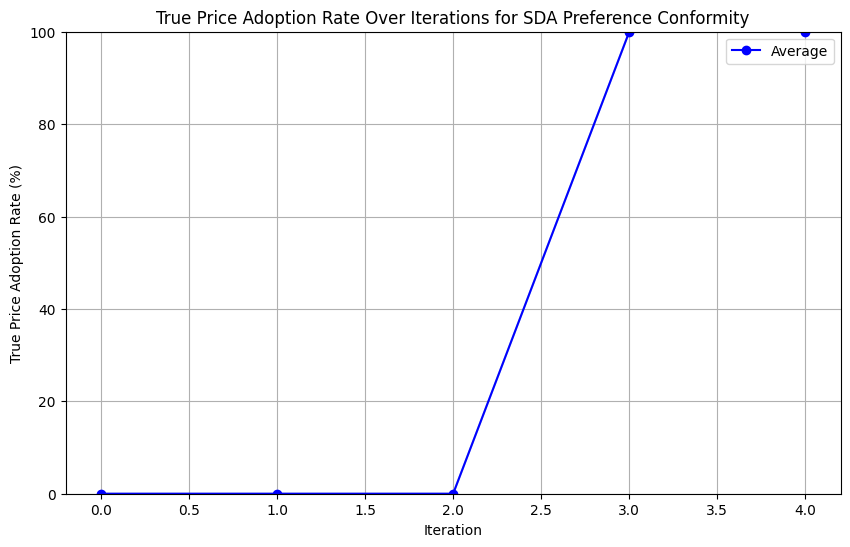

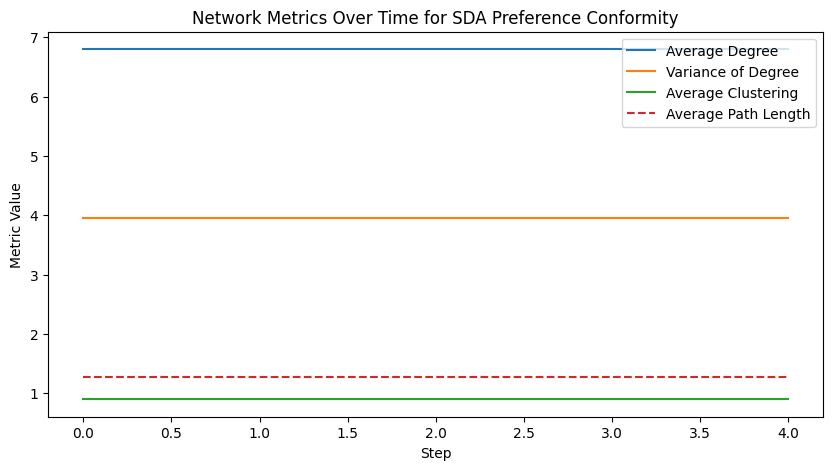

Overall Progress: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


In [16]:
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}

sda_sustainability_config = base_config.copy()
sda_sustainability_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 10,
        'alpha': 3,
        'b': 0.1,
        'homophily_attribute': 'preference_sustainability'
    }
})

network_configurations = {
    'SDA Preference Conformity': sda_sustainability_config
}
num_simulations = 1
num_steps = 5

results = run_all_simulations(network_configurations, num_steps, num_simulations)

Overall Progress: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

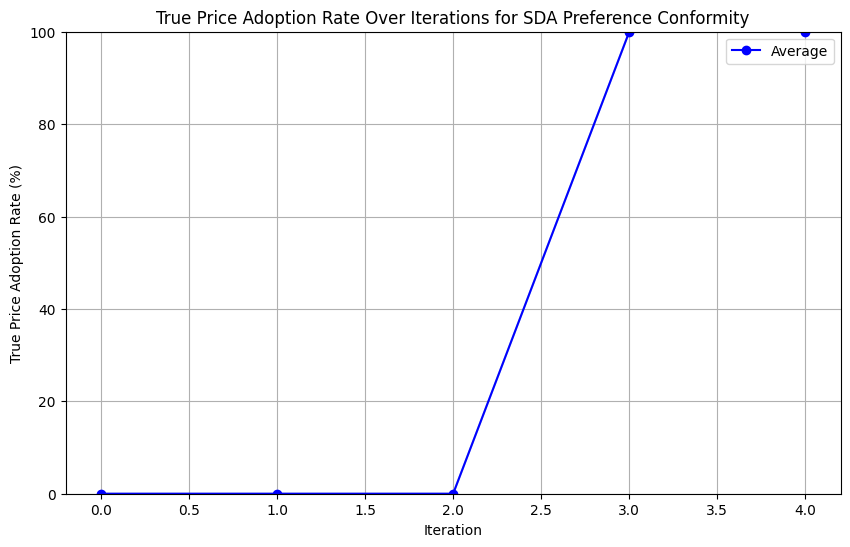

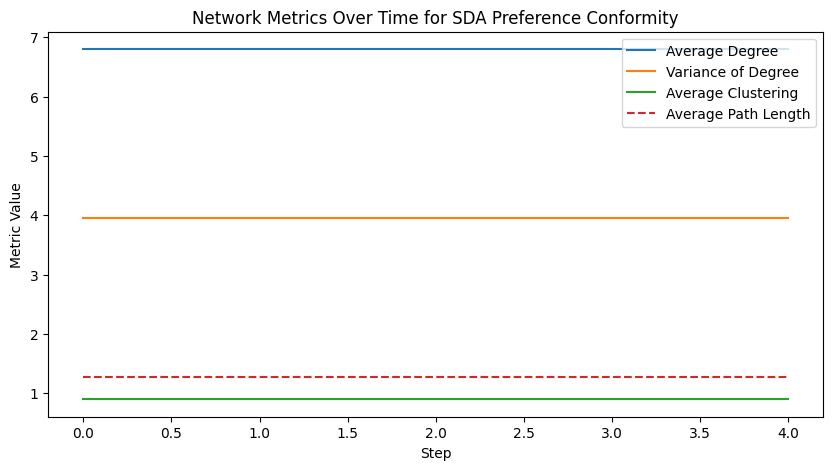

Overall Progress: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


In [17]:
num_simulations = 1
num_steps = 5

results = run_all_simulations(network_configurations, num_steps, num_simulations)


### Multiple runs of the same model:

Overall Progress:   3%|▎         | 1/30 [00:00<00:05,  5.64it/s]

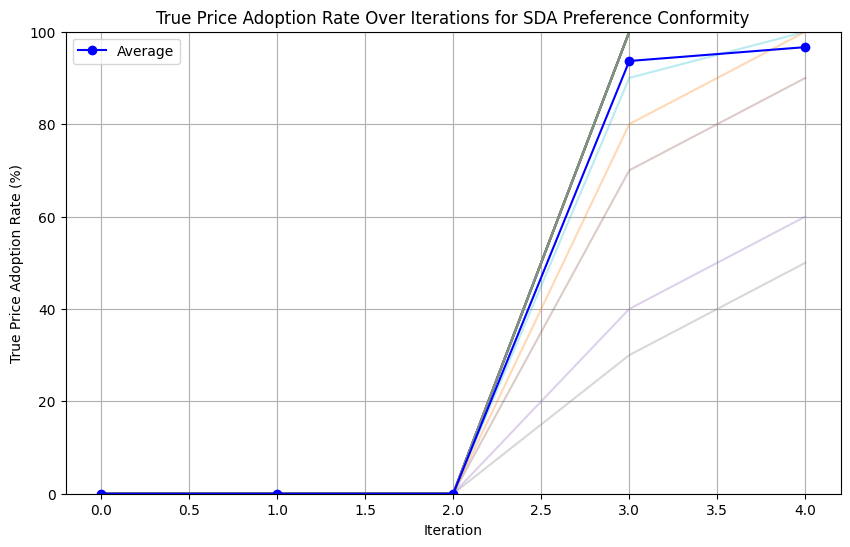

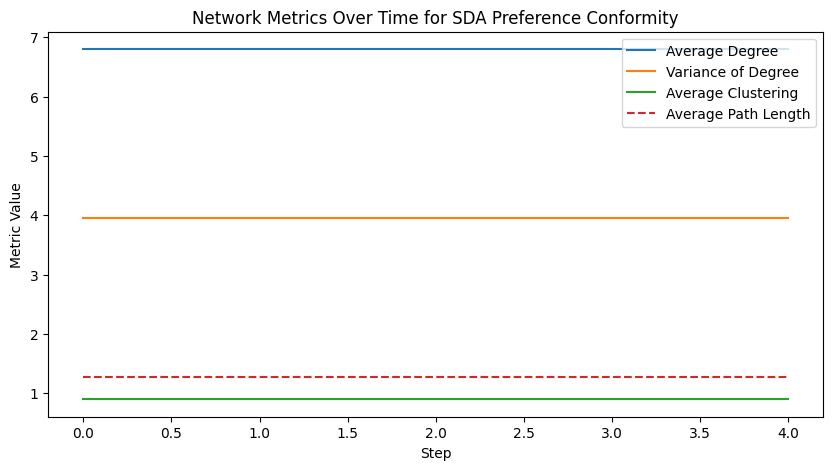

Overall Progress: 100%|██████████| 30/30 [00:00<00:00, 31.36it/s]


In [20]:
# Define the number of simulations and steps
num_simulations = 30
num_steps = 5

# Run all simulations
results = run_all_simulations(network_configurations, num_steps, num_simulations)

### Vary network parameters

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import numpy as np

# Base configuration
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}

# Configuration for SDA networks with different homophily attributes
sda_conformity_config = base_config.copy()
sda_conformity_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'preference_conformity'
    }
})

sda_sustainability_config = base_config.copy()
sda_sustainability_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'preference_sustainability'
    }
})

sda_financial_config = base_config.copy()
sda_financial_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'weight_financial'
    }
})

sda_social_config = base_config.copy()
sda_social_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'weight_social'
    }
})

sda_personal_config = base_config.copy()
sda_personal_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1600,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'weight_personal'
    }
})

def run_simulation_with_varying_network_params(config, parameter_name, parameter_values, num_steps):
    all_results = {}
    for value in parameter_values:
        # Update the network parameter
        config_copy = config.copy()
        config_copy['network_params'][parameter_name] = value
        model = ConsumatModel(config_copy)
        result, _ = run_simulation(model, num_steps)
        all_results[value] = result['Adoption Rates']
    return all_results

# Example for varying 'alpha' and 'b' in SDA networks
alpha_values = np.linspace(1, 10, 5)
b_values = np.linspace(0.01, 0.4, 5)
num_steps = 8

network_configurations = {
    'SDA Preference Conformity': sda_conformity_config,
    'SDA Preference Sustainability': sda_sustainability_config,
    'SDA Weight Financial': sda_financial_config,
    'SDA Weight Social': sda_social_config,
    'SDA Weight Personal': sda_personal_config
}

sda_alpha_results = {}
for network_name, config in network_configurations.items():
    sda_alpha_results[network_name] = run_simulation_with_varying_network_params(
        config,
        'alpha',
        alpha_values,
        num_steps
    )

sda_b_results = {}
for network_name, config in network_configurations.items():
    sda_b_results[network_name] = run_simulation_with_varying_network_params(
        config,
        'b',
        b_values,
        num_steps
    )

# Plot the results for varying alpha
for network_name, results in sda_alpha_results.items():
    plt.figure(figsize=(10, 6))
    for value, adoption_rates in results.items():
        plt.plot(range(num_steps), adoption_rates, label=f'alpha={value:.2f}')
    plt.title(f'Sensitivity Analysis of True Price Adoption Rate on {network_name} (alpha)')
    plt.xlabel('Simulation Steps')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.legend(title='alpha', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Plot the results for varying b
for network_name, results in sda_b_results.items():
    plt.figure(figsize=(10, 6))
    for value, adoption_rates in results.items():
        plt.plot(range(num_steps), adoption_rates, label=f'b={value:.2f}')
    plt.title(f'Sensitivity Analysis of True Price Adoption Rate on {network_name} (b)')
    plt.xlabel('Simulation Steps')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.legend(title='b', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


KeyboardInterrupt: 

### Vary True Price percentage

Running simulations for Watts-Strogatz network...


TP Percentage Progress: 100%|██████████| 19/19 [05:47<00:00, 18.27s/it]


Running simulations for Barabasi-Albert network...


TP Percentage Progress: 100%|██████████| 19/19 [05:39<00:00, 17.85s/it]


Running simulations for Random Regular network...


TP Percentage Progress: 100%|██████████| 19/19 [05:35<00:00, 17.67s/it]


Running simulations for Holme-Kim network...


TP Percentage Progress: 100%|██████████| 19/19 [05:37<00:00, 17.76s/it]


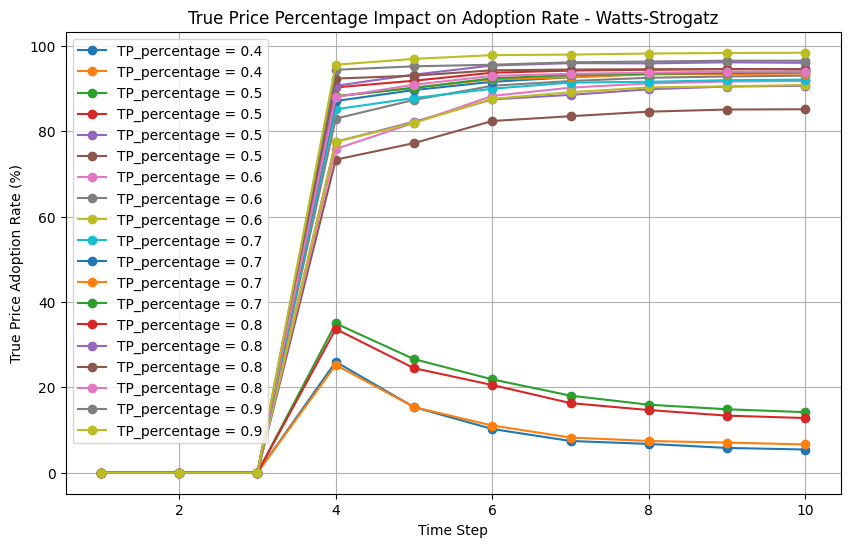

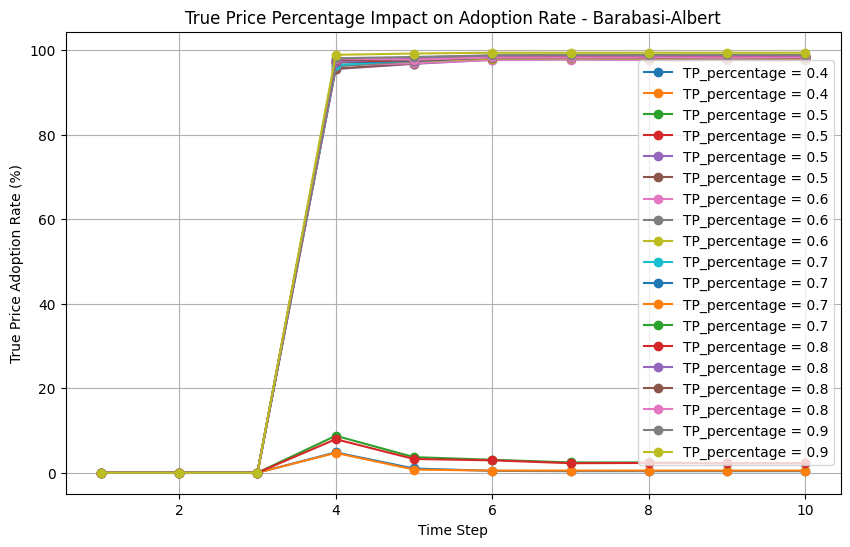

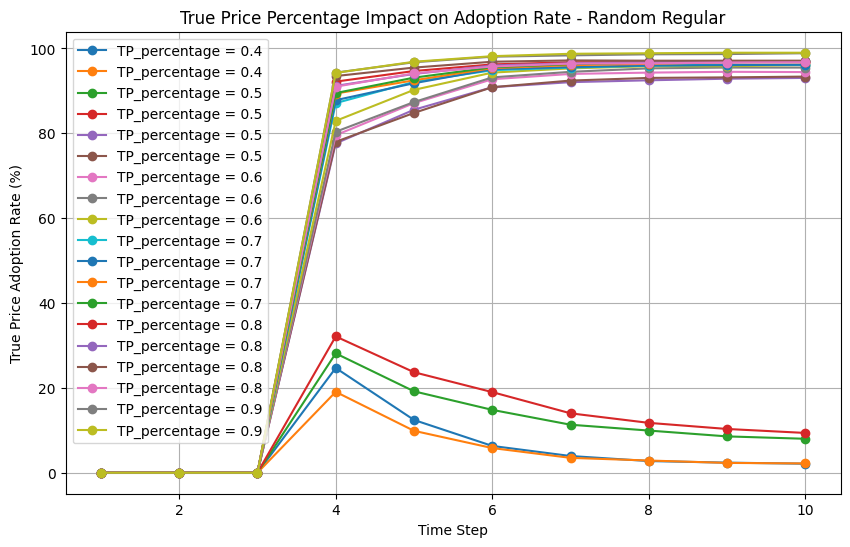

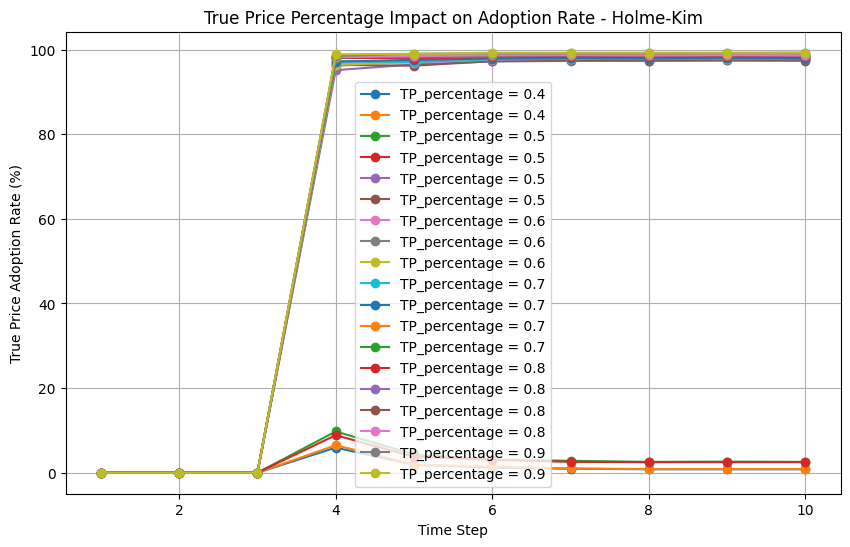

In [ ]:
#Define a range of values for TP_percentage
tp_percentages = np.linspace(0.4, 0.9, 5)  # From 40% to 90%

# Function to run simulations for each TP_percentage
def run_simulation_for_tp_percentage(config, tp_percentages, num_steps):
    adoption_rates_by_tp_percentage = []

    for tp_percentage in tqdm(tp_percentages, desc='TP Percentage Progress'):
        # Update the config with the current TP_percentage
        config_copy = config.copy()
        config_copy['TP_percentage'] = tp_percentage
        
        # Run the simulation
        model = ConsumatModel(config_copy)
        model_data, _ = run_simulation(model, num_steps)
        
        # Extract the adoption rates from the DataFrame
        adoption_rates = model_data['Adoption Rates'].values
        
        # Store the adoption rates for this TP_percentage
        adoption_rates_by_tp_percentage.append(adoption_rates)
    
    return adoption_rates_by_tp_percentage

# Run simulations and collect results for all SDA networks
sda_network_configurations = {
    'SDA Preference Conformity': sda_conformity_config,
    'SDA Preference Sustainability': sda_sustainability_config,
    'SDA Weight Financial': sda_financial_config,
    'SDA Weight Social': sda_social_config,
    'SDA Weight Personal': sda_personal_config
}

sda_results = {}
for network_name, config in sda_network_configurations.items():
    print(f"Running simulations for {network_name} network...")
    adoption_rates_by_tp_percentage = run_simulation_for_tp_percentage(config, tp_percentages, num_steps)
    sda_results[network_name] = adoption_rates_by_tp_percentage

# Plot the results for each SDA network
for network_name, adoption_rates_by_tp_percentage in sda_results.items():
    plt.figure(figsize=(10, 6))
    for i, tp_percentage in enumerate(tp_percentages):
        plt.plot(range(1, num_steps + 1), adoption_rates_by_tp_percentage[i], label=f'TP_percentage = {tp_percentage:.1f}', marker='o')
    plt.title(f'True Price Percentage Impact on Adoption Rate - {network_name}')
    plt.xlabel('Time Step')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

Running simulations for Watts-Strogatz network...


TP Percentage Progress: 100%|██████████| 19/19 [09:43<00:00, 30.71s/it]


Running simulations for Barabasi-Albert network...


TP Percentage Progress: 100%|██████████| 19/19 [09:39<00:00, 30.51s/it]


Running simulations for Random Regular network...


TP Percentage Progress: 100%|██████████| 19/19 [09:29<00:00, 29.99s/it]


Running simulations for Holme-Kim network...


TP Percentage Progress: 100%|██████████| 19/19 [09:39<00:00, 30.50s/it]


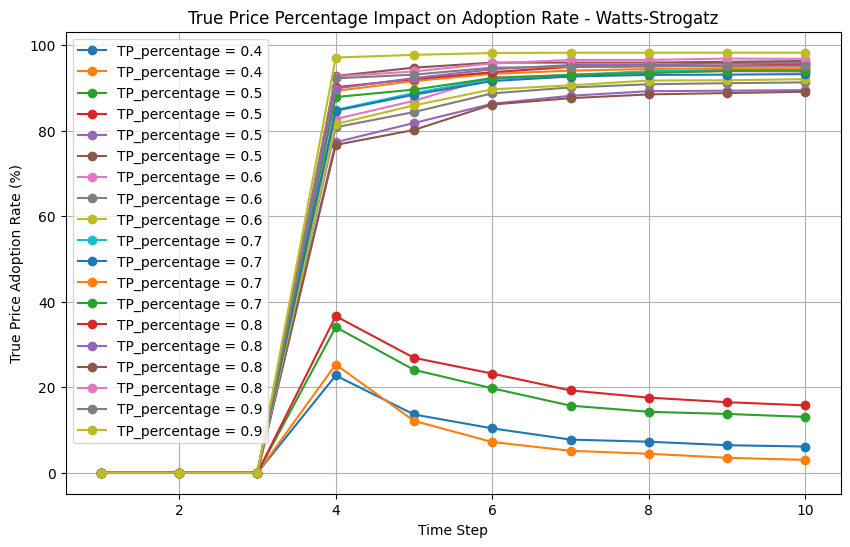

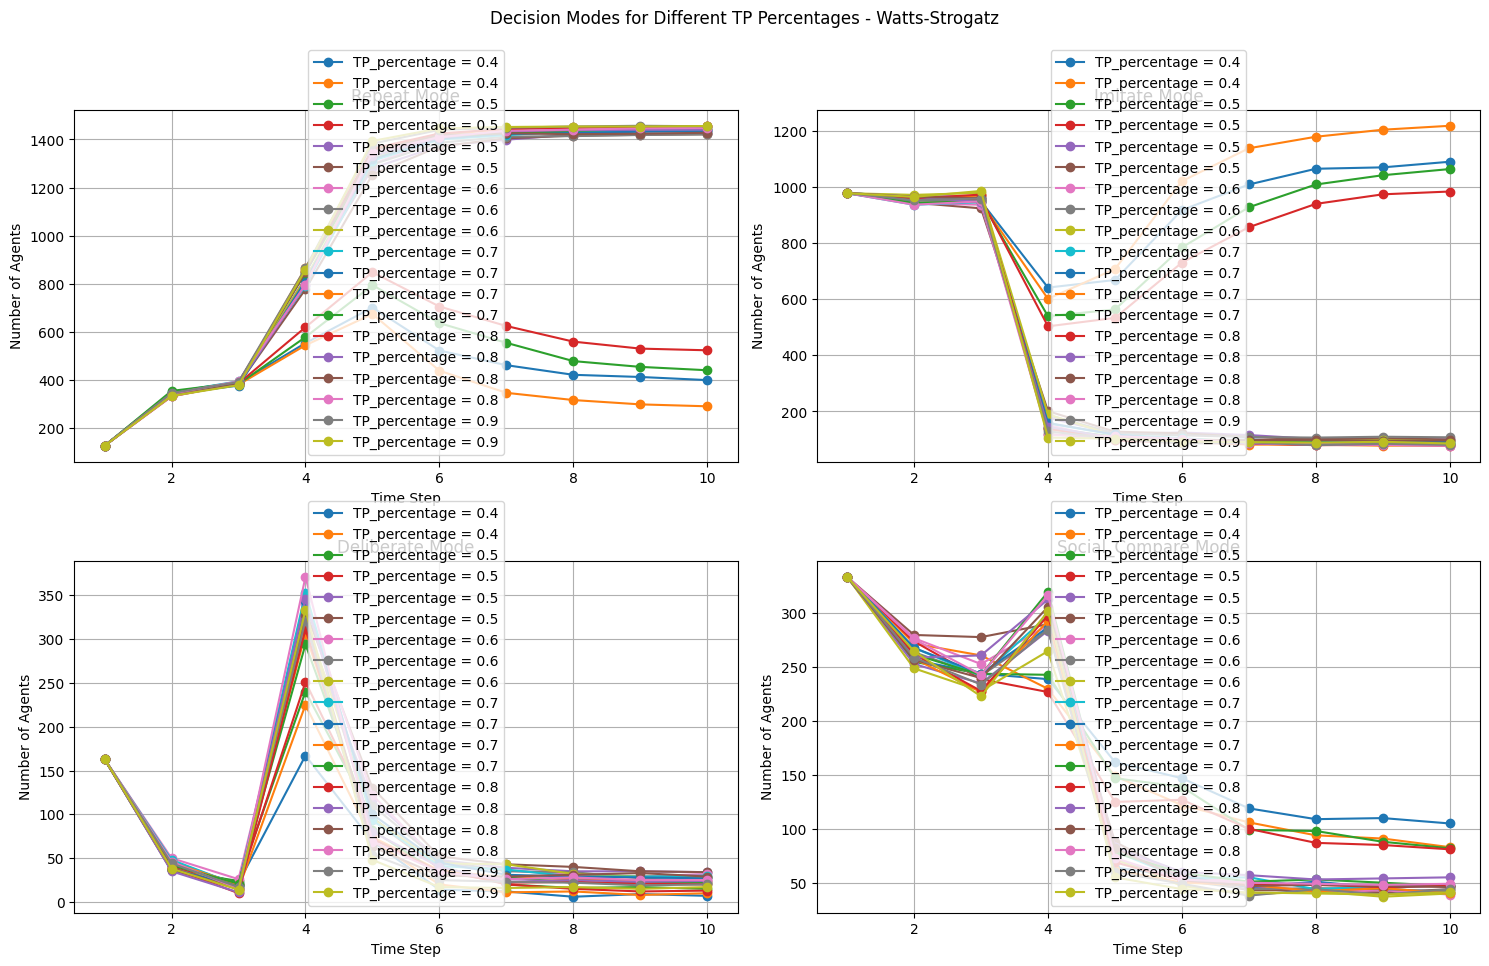

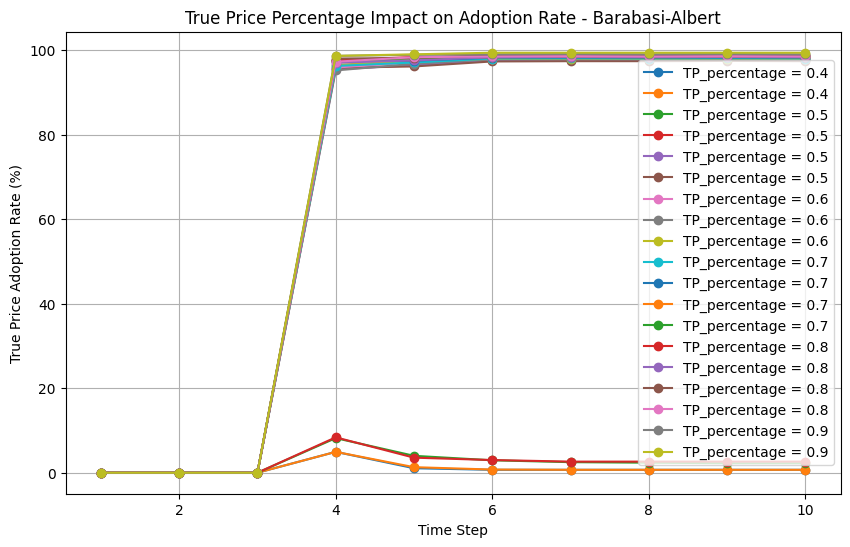

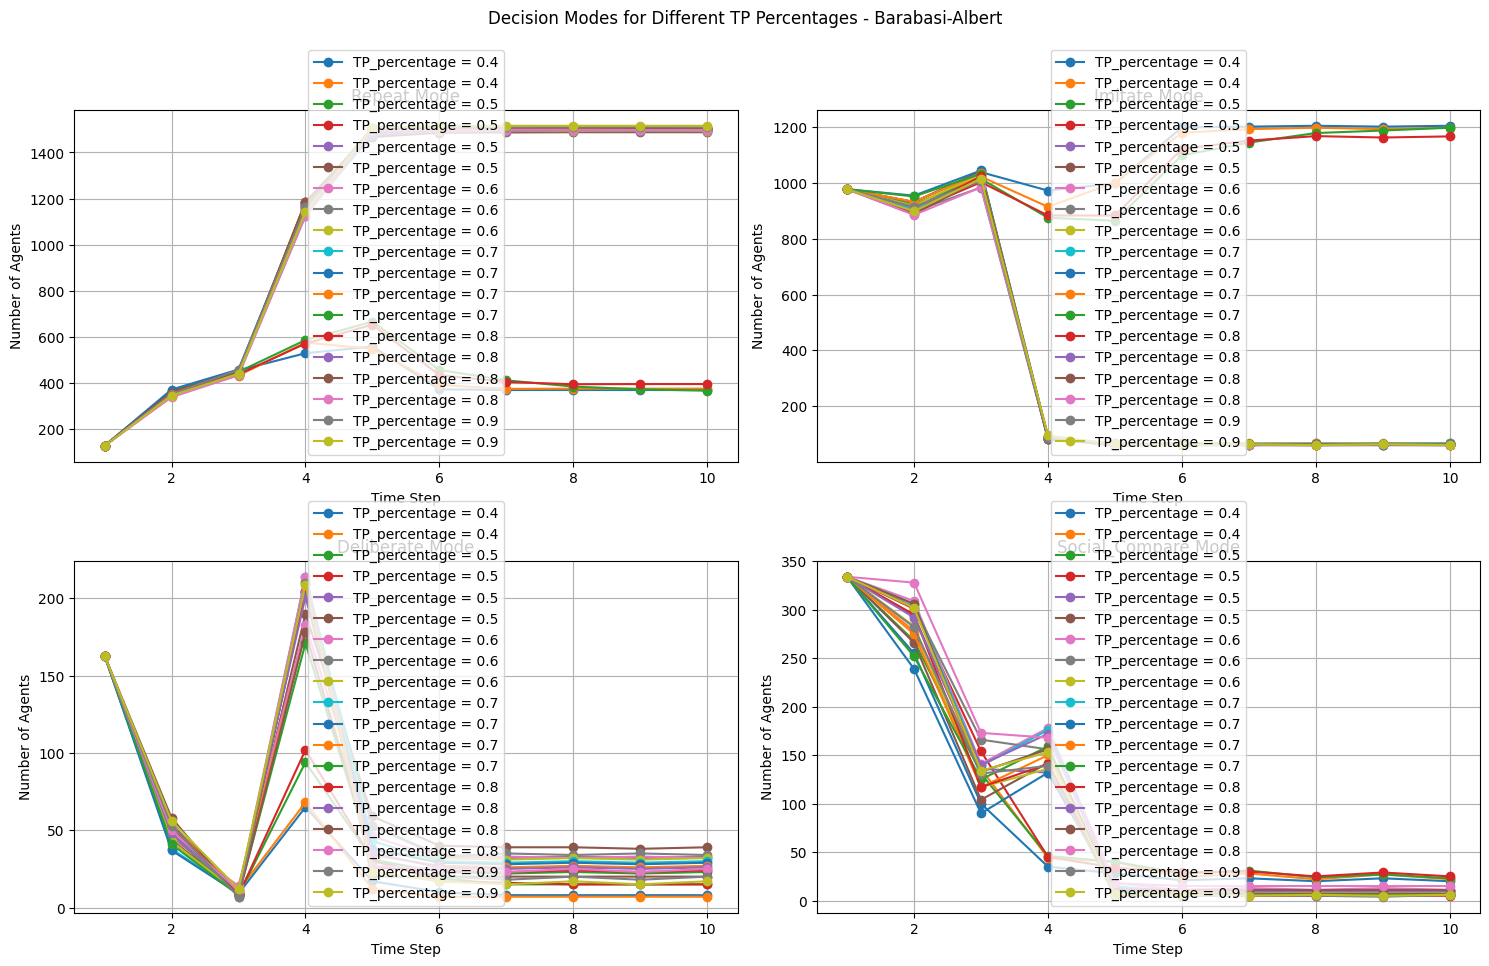

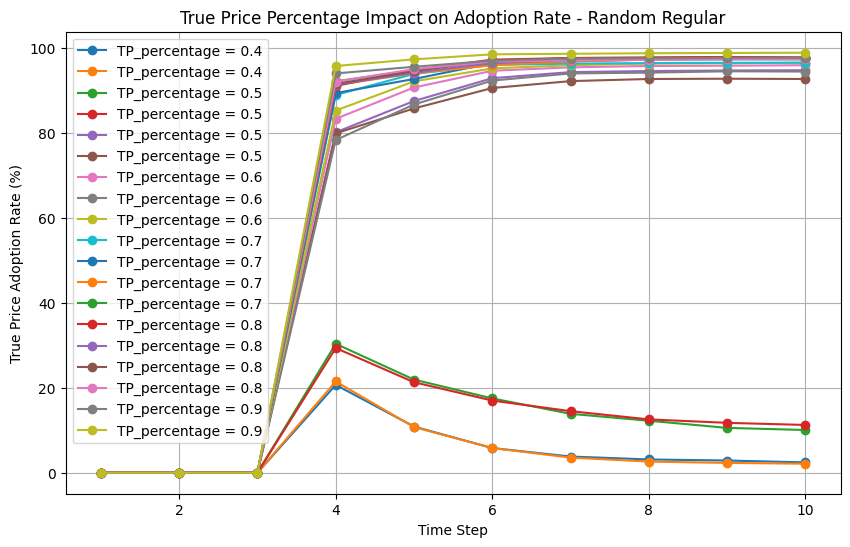

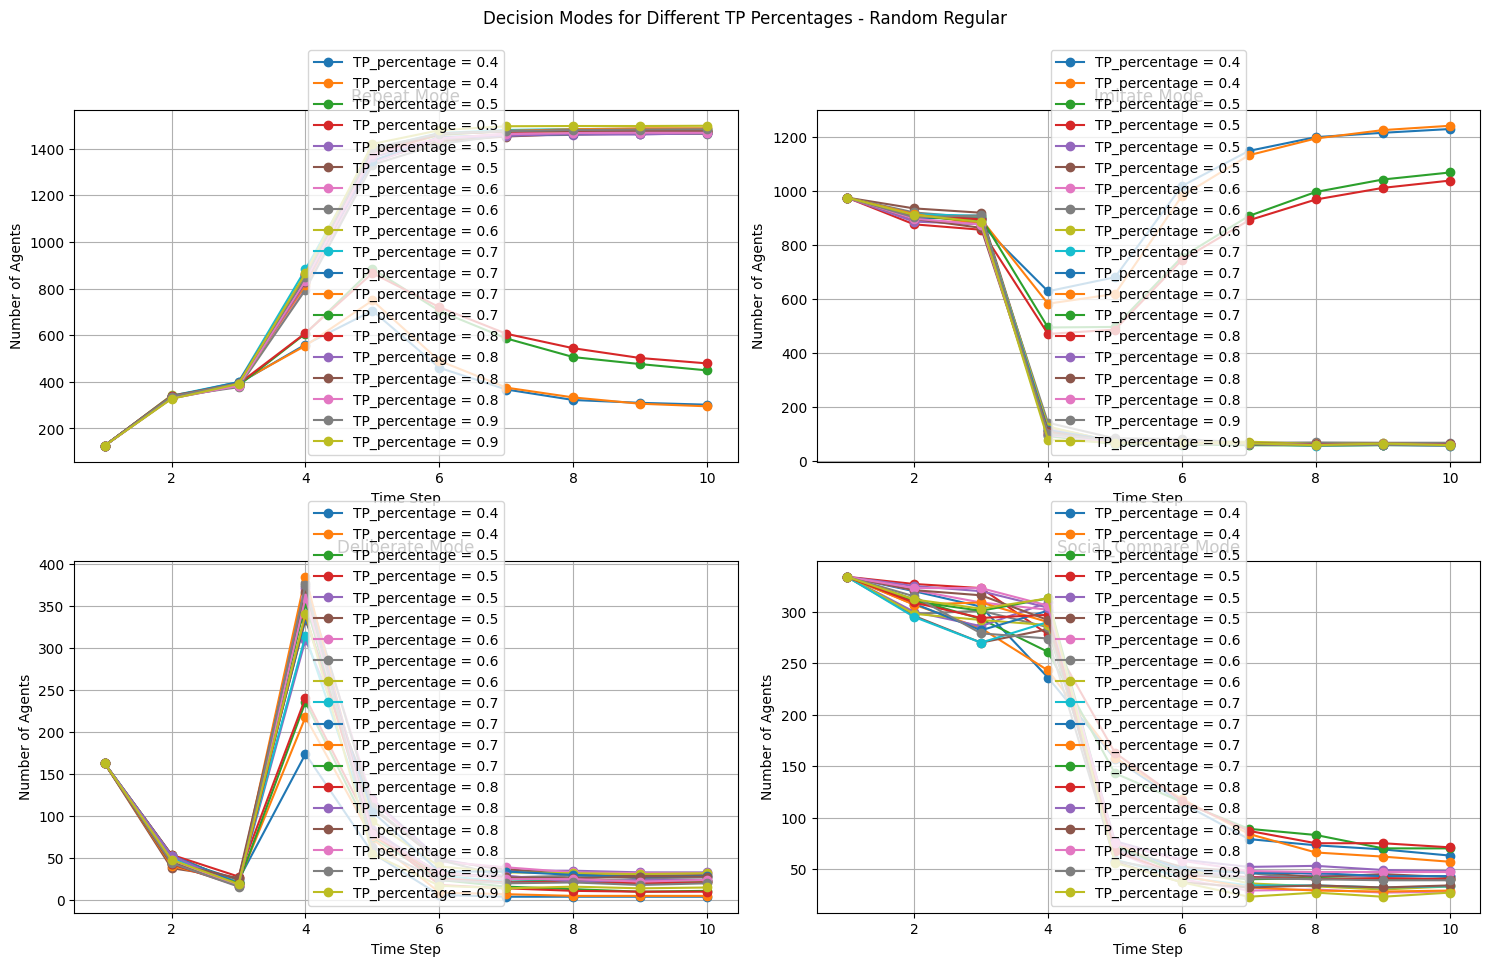

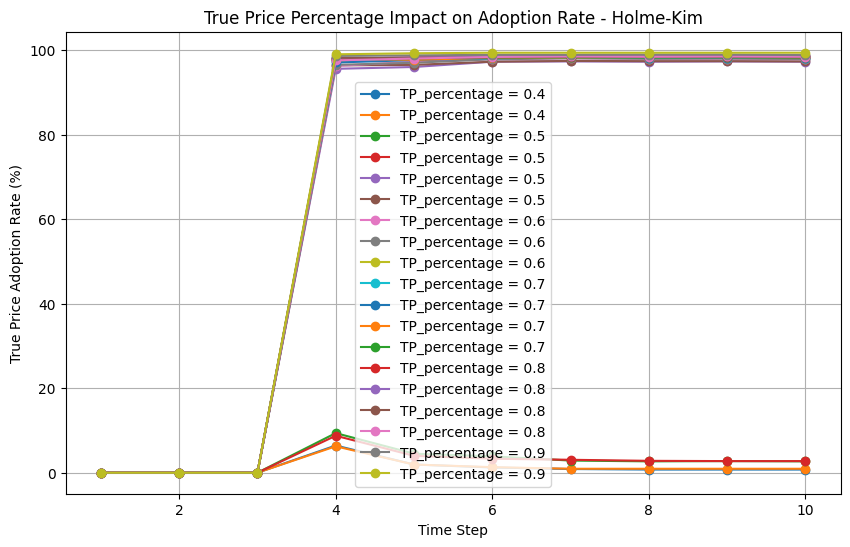

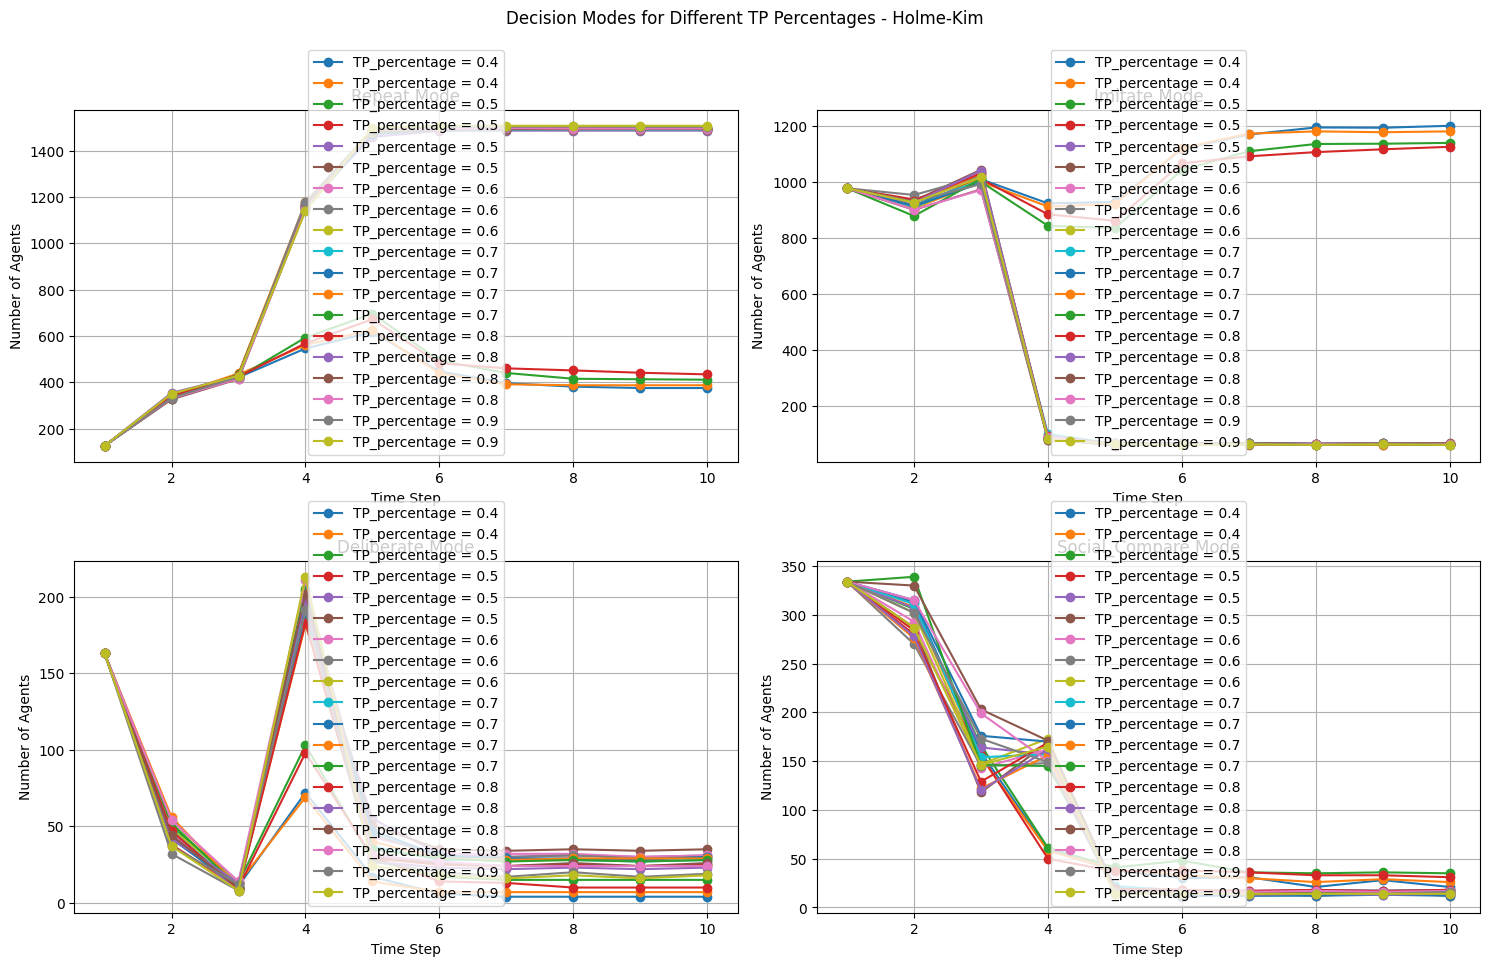

In [21]:
def run_simulation_for_tp_percentage(config, tp_percentages, num_steps):
    results_by_tp_percentage = []

    for tp_percentage in tqdm(tp_percentages, desc='TP Percentage Progress'):
        # Update the config with the current TP_percentage
        config['TP_percentage'] = tp_percentage
        
        # Run the simulation
        model = ConsumatModel(config)
        model_data, agent_data = run_simulation(model, num_steps)
        
        # Extract the adoption rates and decision modes from the DataFrame
        adoption_rates = model_data['Adoption Rates'].values
        decision_modes_count = generate_decision_modes_count(agent_data)
        
        # Store the adoption rates and decision modes for this TP_percentage
        results_by_tp_percentage.append((adoption_rates, decision_modes_count))
    
    return results_by_tp_percentage
# Base configuration
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}

# Network configurations
network_configs = {
    'Watts-Strogatz': {
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1600,
            'k': 4,
            'p': 0.2
        }
    },
    'Barabasi-Albert': {
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1600,
            'm': 4
        }
    },
    'Random Regular': {
        'network_type': 'random_regular',
        'network_params': {
            'n': 1600,
            'd': 4
        }
    },
    'Holme-Kim': {
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 4,
            'p': 0.1
        }
    }
}

# Define a range of values for TP_percentage
tp_percentages = np.linspace(0.4, 0.9, 19)  # From 40% to 90%

# Hold the number of steps constant for each simulation
num_steps = 10

# Function to generate decision modes count DataFrame
def generate_decision_modes_count(agent_data):
    decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
    return decision_modes_count

# Run simulations and collect results for all networks
all_network_results = {}
for network_name, network_config in network_configs.items():
    print(f"Running simulations for {network_name} network...")
    config = base_config.copy()
    config.update(network_config)
    results_by_tp_percentage = run_simulation_for_tp_percentage(config, tp_percentages, num_steps)
    all_network_results[network_name] = results_by_tp_percentage

# Plot the results for each network
for network_name, results_by_tp_percentage in all_network_results.items():
    # Plot True Price Adoption Rates
    plt.figure(figsize=(10, 6))
    for i, (adoption_rates, _) in enumerate(results_by_tp_percentage):
        plt.plot(range(1, num_steps + 1), adoption_rates, label=f'TP_percentage = {tp_percentages[i]:.1f}', marker='o')
    plt.title(f'True Price Percentage Impact on Adoption Rate - {network_name}')
    plt.xlabel('Time Step')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Decision Modes
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Decision Modes for Different TP Percentages - {network_name}')

    mode_labels = ['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']
    for idx, mode in enumerate(mode_labels):
        ax = axs[idx // 2, idx % 2]
        for i, (_, decision_modes_count) in enumerate(results_by_tp_percentage):
            ax.plot(decision_modes_count.index, decision_modes_count[mode], label=f'TP_percentage = {tp_percentages[i]:.1f}', marker='o')
        ax.set_title(f'{mode} Mode')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Number of Agents')
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Network: watts_strogatz
Average degree: 4.0
Rewiring probability: 0.2
Clustering coefficient: 0.28151428571428544
Average path length: 7.011283283283284
Degree distribution: (array([  0,   0,  28, 206, 540, 194,  32]), array([0, 1, 2, 3, 4, 5, 6, 7]))
Agent 0 has 4 neighbors
Agent 1 has 4 neighbors
Agent 2 has 6 neighbors
Agent 3 has 4 neighbors
Agent 4 has 3 neighbors


Simulation Progress: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Network: barabasi_albert
Average degree: 7.968
Rewiring probability: N/A
Clustering coefficient: 0.03336718002479007
Average path length: 3.1895575575575577
Degree distribution: (array([  0,   0,   0,   0, 329, 190, 119,  84,  44,  41,  32,  22,  21,
        16,  12,   9,  10,   7,  10,   6,   4,   4,   3,   6,   1,   2,
         0,   1,   1,   1,   0,   2,   1,   2,   1,   2,   2,   1,   2,
         0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   1,   0,   1,   0,   0,   1,   0,   1,   0,   1,   0,   0,
         0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1]), array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22, 

Simulation Progress: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Network: random_regular
Average degree: 4.0
Rewiring probability: N/A
Clustering coefficient: 0.0024999999999999996
Average path length: 5.645251251251251
Degree distribution: (array([   0,    0,    0, 1000]), array([0, 1, 2, 3, 4]))
Agent 0 has 4 neighbors
Agent 1 has 4 neighbors
Agent 2 has 4 neighbors
Agent 3 has 4 neighbors
Agent 4 has 4 neighbors


Simulation Progress: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Network: holme_kim
Average degree: 7.96
Rewiring probability: 0.1
Clustering coefficient: 0.07129409977493154
Average path length: 3.1996856856856857
Degree distribution: (array([  0,   0,   0,   1, 331, 197, 120,  77,  49,  41,  26,  17,  22,
        15,  12,   9,   8,   8,  11,   7,   8,   3,   2,   1,   2,   0,
         1,   2,   1,   1,   3,   2,   0,   3,   0,   0,   2,   2,   0,
         2,   0,   2,   1,   0,   0,   0,   0,   0,   0,   1,   0,   0,
         0,   1,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1,
         1,   0,   2,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65

Simulation Progress: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


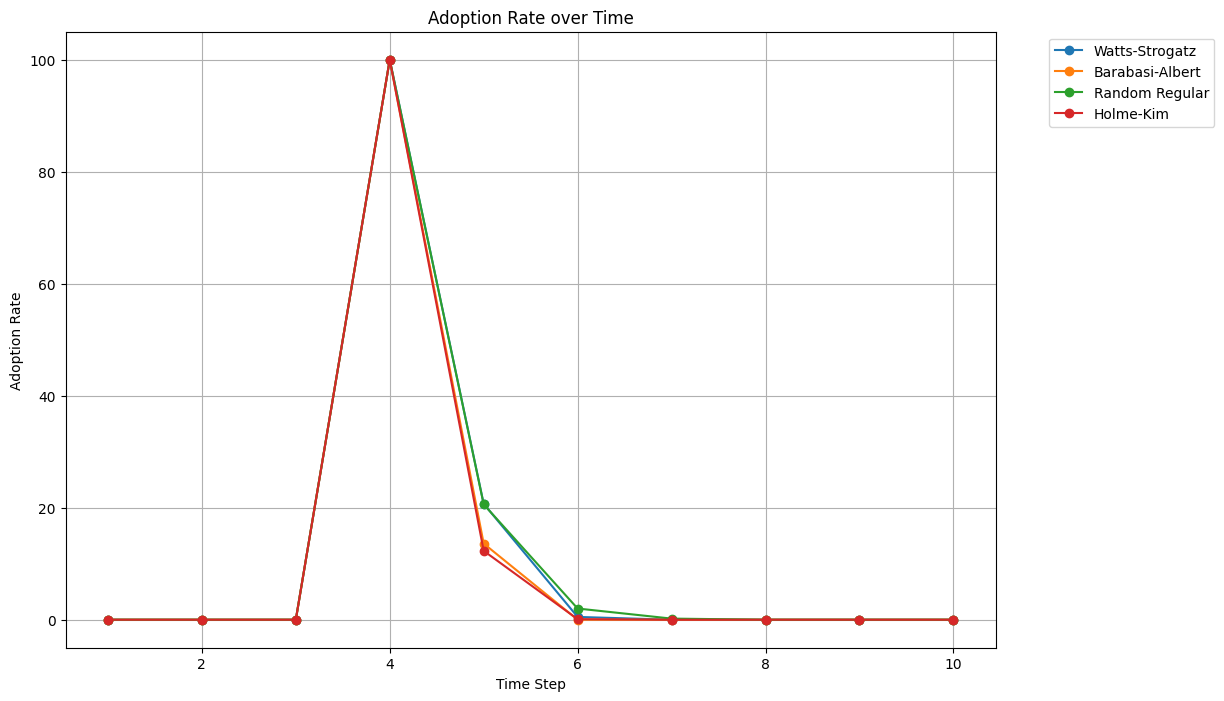

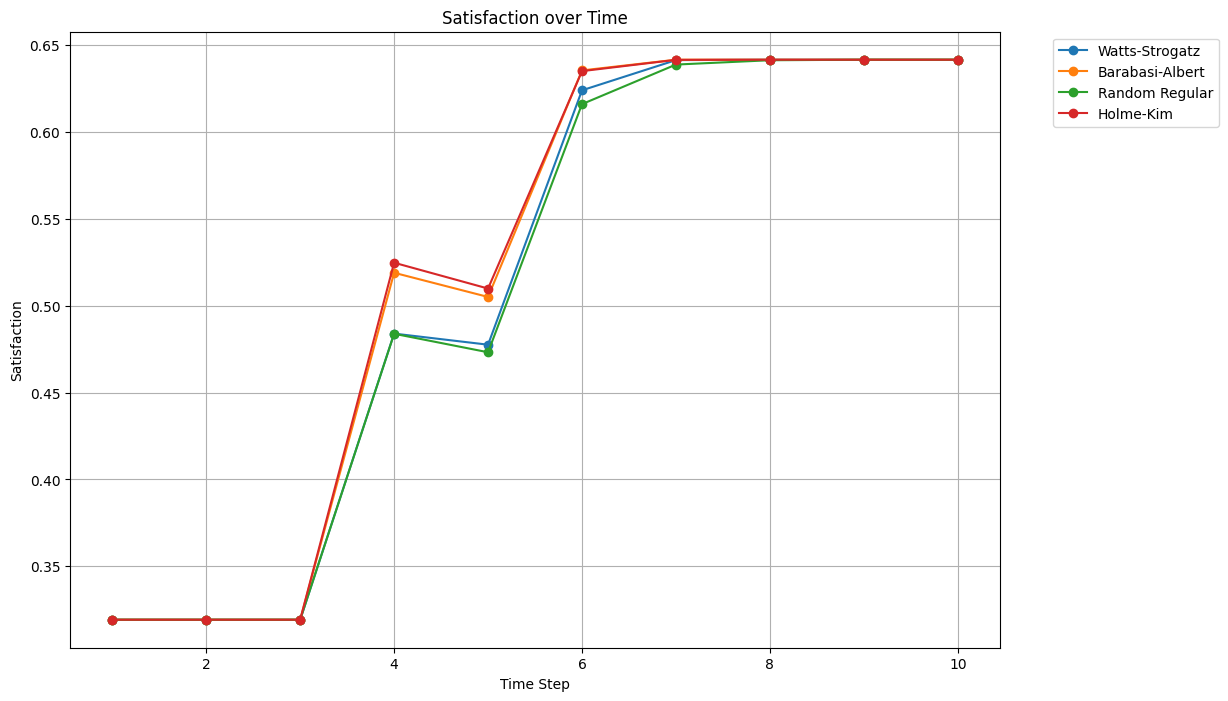

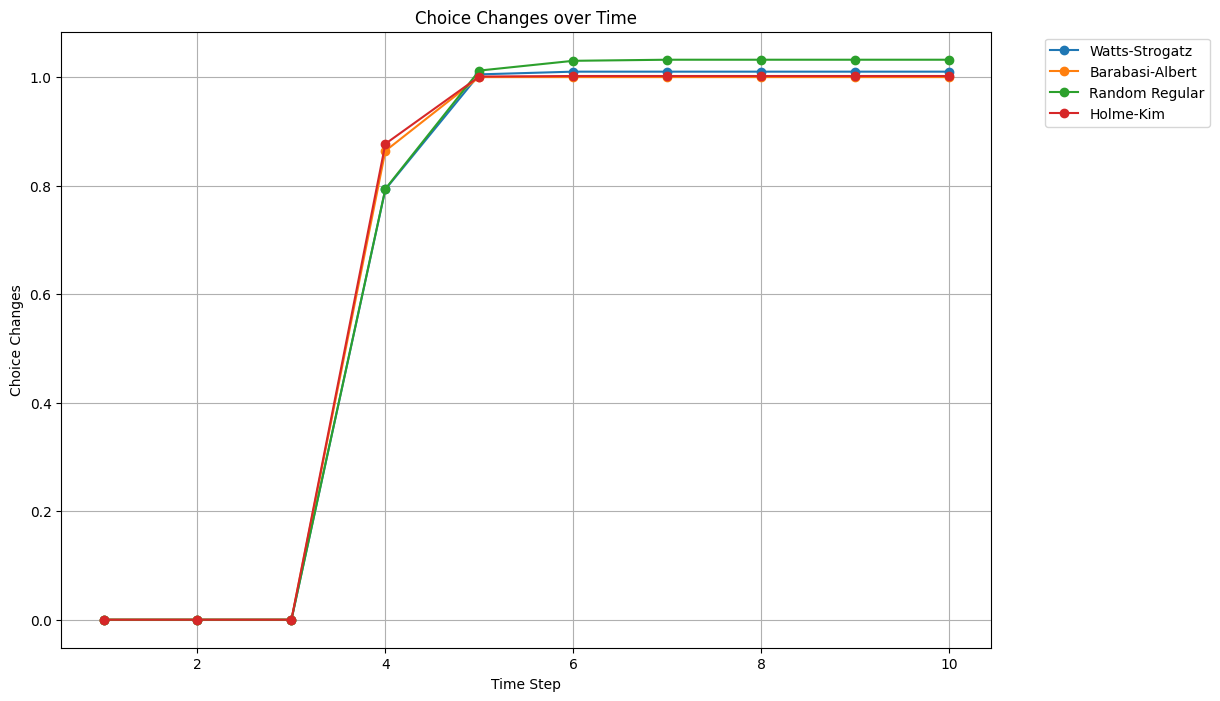

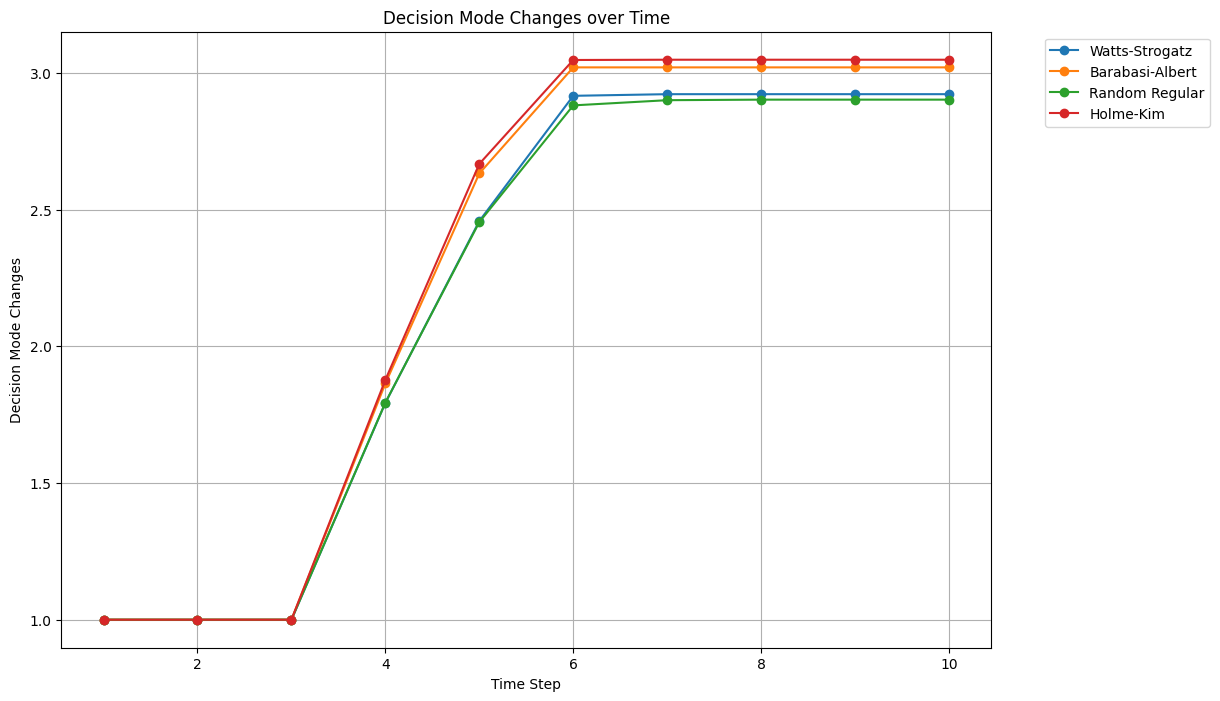

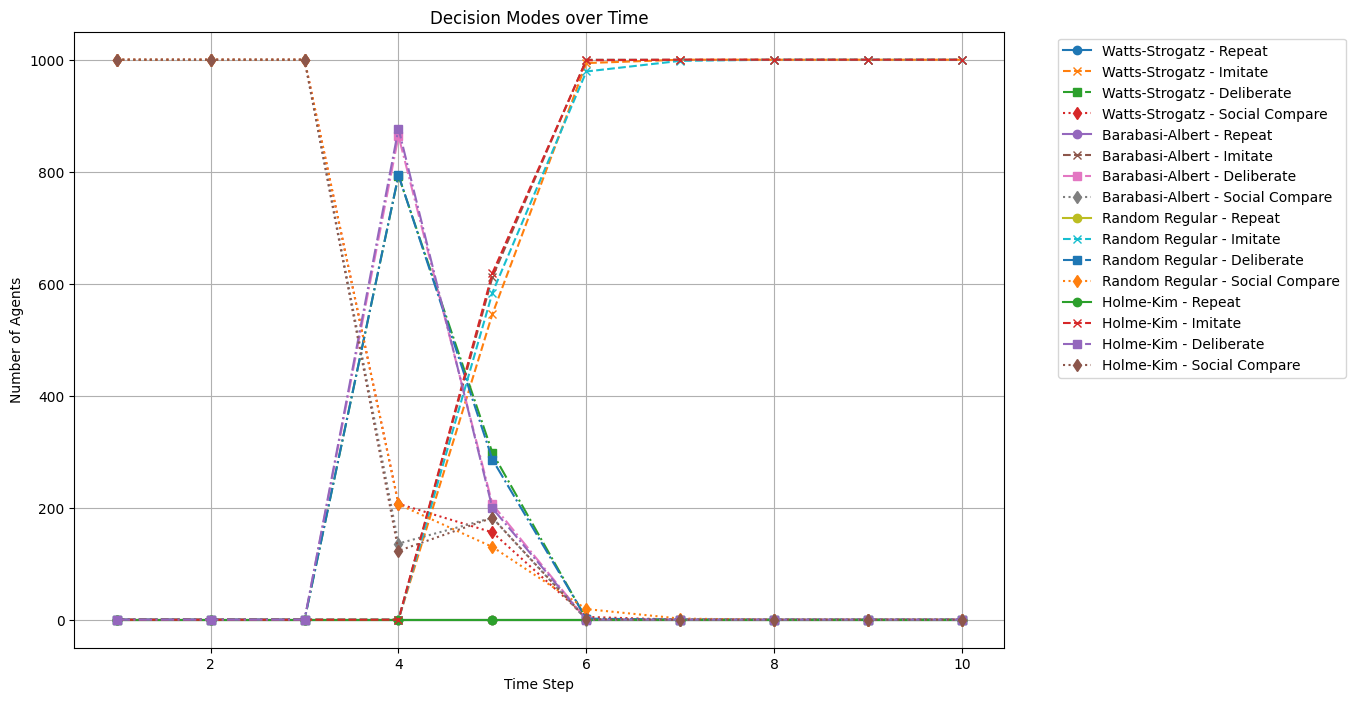

In [18]:

# Base configuration
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}

# Network configurations with a constant 'degree' parameter
network_configs = {
    'Watts-Strogatz': {
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1600,
            'k': 4,  
            'p': 0.2
        }
    },
    'Barabasi-Albert': {
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1600,
            'm': 4  
        }
    },
    'Random Regular': {
        'network_type': 'random_regular',
        'network_params': {
            'n': 1600,
            'd': 4  
        }
    },
    'Holme-Kim': {
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 4,  
            'p': 0.1
        }
    }
}

# Hold the number of steps constant for each simulation
num_steps = 10

# Function to run simulations for the network configurations
def run_simulation_for_networks(config, num_steps):
    results = { 'Adoption Rate': [], 'Satisfaction': [], 'Choice Changes': [], 'Decision Mode Changes': [], 'Decision Modes': [] }

    # Run the simulation
    model = ConsumatModel(config)

    # Debug: Print network properties
    G = model.get_network()
    print(f"Network: {config['network_type']}")
    print(f"Average degree: {np.mean([d for n, d in G.degree()])}")
    print(f"Rewiring probability: {config['network_params'].get('p', 'N/A')}")
    print(f"Clustering coefficient: {nx.average_clustering(G)}")
    if nx.is_connected(G):
        print(f"Average path length: {nx.average_shortest_path_length(G)}")
    else:
        print("Network is not connected")

    # Print the degree distribution
    degrees = [d for n, d in G.degree()]
    print(f"Degree distribution: {np.histogram(degrees, bins=range(max(degrees) + 1))}")

    # Check agent neighbors
    for agent in model.schedule.agents[:5]:  # Check the first 5 agents
        neighbors = model.get_neighbors_for_agent(agent)
        print(f"Agent {agent.unique_id} has {len(neighbors)} neighbors")
    
    model_data = run_simulation(model, num_steps)
    
    # Extract the metrics from the DataFrame
    adoption_rates = model_data['True_Price_Adoption_Rate'].values
    average_satisfaction = model_data['Average_Satisfaction'].values
    average_choice_changes = model_data['Average_Choice_Changes'].values
    average_decision_mode_changes = model_data['Average_Decision_Mode_Changes'].values
    
    # Store the metrics for this network
    results['Adoption Rate'].append(adoption_rates)
    results['Satisfaction'].append(average_satisfaction)
    results['Choice Changes'].append(average_choice_changes)
    results['Decision Mode Changes'].append(average_decision_mode_changes)
    
    # Collect decision modes count over time
    agent_data = model.datacollector.get_agent_vars_dataframe()
    decision_modes_count = agent_data.groupby('Step').sum()[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']]
    results['Decision Modes'] = decision_modes_count
    
    return results

# Run simulations and collect results for all networks
all_network_results = {}
for network_name, network_config in network_configs.items():
    config = base_config.copy()
    config.update(network_config)
    results = run_simulation_for_networks(config, num_steps)
    all_network_results[network_name] = results

# Plot the results for each metric
metrics = ['Adoption Rate', 'Satisfaction', 'Choice Changes', 'Decision Mode Changes']
for metric in metrics:
    plt.figure(figsize=(12, 8))
    for network_name, results in all_network_results.items():
        plt.plot(range(1, num_steps + 1), results[metric][0], label=f'{network_name}', marker='o')
    plt.title(f'{metric} over Time')
    plt.xlabel('Time Step')
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Plot the decision modes count over time for each network
plt.figure(figsize=(12, 8))
for network_name, results in all_network_results.items():
    decision_modes_count = results['Decision Modes']
    plt.plot(decision_modes_count.index, decision_modes_count['Repeat'], label=f'{network_name} - Repeat', linestyle='-', marker='o')
    plt.plot(decision_modes_count.index, decision_modes_count['Imitate'], label=f'{network_name} - Imitate', linestyle='--', marker='x')
    plt.plot(decision_modes_count.index, decision_modes_count['Deliberate'], label=f'{network_name} - Deliberate', linestyle='-.', marker='s')
    plt.plot(decision_modes_count.index, decision_modes_count['Social_Compare'], label=f'{network_name} - Social Compare', linestyle=':', marker='d')
plt.title('Decision Modes over Time')
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


## Global Sensitivity Analysis

Sobol indices

Saltelli sampling

Pick key parameters (e.g. alpha, beta, rewiring probability) and key measures (true price adoption rate...)

### Sensitivity Analysis

### GSA

In [26]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the model inputs for each network type
network_problems = {
    'Watts-Strogatz': {
        'num_vars': 5,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'k', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1], [2, 10], [0, 1]]  # Define bounds for k and p
    },
    'Barabasi-Albert': {
        'num_vars': 4,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'm'],
        'bounds': [[0, 1], [0, 1], [0, 1], [1, 10]]  # Define bounds for m
    },
    'Random Regular': {
        'num_vars': 4,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'd'],
        'bounds': [[0, 1], [0, 1], [0, 1], [2, 10]]  # Define bounds for d
    },
    'Holme-Kim': {
        'num_vars': 5,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'm', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1], [1, 10], [0, 1]]  # Define bounds for m and p
    }
}

In [30]:
# Number of samples
num_samples = 4

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_55917/3267385317.py:7: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


In [31]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
import json

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[3])
        config['network_params']['p'] = params[4]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[3])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[3])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[3])
        config['network_params']['p'] = params[4]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name}')
    )
    return np.array(all_results)

num_steps = 10

# Run GSA for each network
for network_name, config in network_configurations.items():
    print(f"Running GSA for {network_name} network...")
    config = base_config.copy()
    config.update(network_configs[network_name])
    all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], num_steps)
    
    results = {}
    
    # Perform Sobol sensitivity analysis
    for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
        Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True)
        results[output] = {
            'S1': Si['S1'].tolist(),
            'ST': Si['ST'].tolist(),
            'S2': Si['S2'].tolist()
        }
        print(f'Sensitivity analysis for {output} ({network_name} network):')
        print(Si)
    
    # Save results to a JSON file
    with open(f'sensitivity_results_{network_name}.json', 'w') as f:
        json.dump(results, f)


Running GSA for Watts-Strogatz network...


Running simulations for Watts-Strogatz: 100%|██████████| 48/48 [03:59<00:00,  4.99s/it]


                              ST   ST_conf
TP_percentage           1.576779  0.945632
satisfaction_threshold  0.661384  1.909575
uncertainty_threshold   0.456017  1.651167
k                       0.434155  1.572045
p                       0.636234  2.303771
                              S1   S1_conf
TP_percentage           1.484003  0.726770
satisfaction_threshold -0.226758  1.995651
uncertainty_threshold  -0.493979  1.766538
k                      -0.473747  1.726183
p                      -0.571578  2.092057
                                                       S2   S2_conf
(TP_percentage, satisfaction_threshold)         -0.109104  2.477916
(TP_percentage, uncertainty_threshold)          -0.058032  2.197665
(TP_percentage, k)                              -0.098772  2.106847
(TP_percentage, p)                               0.118082  2.899932
(satisfaction_threshold, uncertainty_threshold)  0.152186  1.966042
(satisfaction_threshold, k)                      0.153763  1.966346
(satisfa

KeyboardInterrupt: 

PAWN sensitivity analysis

In [32]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import resample
from scipy.stats import ks_2samp
from joblib import Parallel, delayed

# Base configuration
base_config = {
    'TP_percentage': 0.6,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'num_agents': 1600,
    'seed': 42  # Seed for reproducibility
}

# Network configurations
network_configs = {
    'Watts-Strogatz': {
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1600,
            'k': 8,
            'p': 0.3
        }
    },
    'Barabasi-Albert': {
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1600,
            'm': 8
        }
    },
    'Random Regular': {
        'network_type': 'random_regular',
        'network_params': {
            'n': 1600,
            'd': 8
        }
    },
    'Holme-Kim': {
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 8,
            'p': 0.3
        }
    }
}

# Define the parameter bounds for each network type
network_bounds = {
    'Watts-Strogatz': [[0, 1], [0, 1], [0, 1], [2, 20], [0, 1]],
    'Barabasi-Albert': [[0, 1], [0, 1], [0, 1], [2, 20]],
    'Random Regular': [[0, 1], [0, 1], [0, 1], [2, 20]],
    'Holme-Kim': [[0, 1], [0, 1], [0, 1], [2, 20], [0, 1]]
}

# Parameter names for each network type
network_params = {
    'Watts-Strogatz': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'k', 'p'],
    'Barabasi-Albert': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'm'],
    'Random Regular': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'd'],
    'Holme-Kim': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'm', 'p']
}

# Define the number of samples
num_samples = 2560
num_steps = 10

# Generate samples using Latin Hypercube Sampling (LHS)
param_values = {}
for network_name in network_configs.keys():
    param_values[network_name] = np.random.rand(num_samples, len(network_bounds[network_name]))
    for i, bounds in enumerate(network_bounds[network_name]):
        param_values[network_name][:, i] = param_values[network_name][:, i] * (bounds[1] - bounds[0]) + bounds[0]

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[3])
        config['network_params']['p'] = params[4]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[3])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[3])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[3])
        config['network_params']['p'] = params[4]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]
    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name}')
    )
    return np.array(all_results)

# Run GSA for each network
for network_name, config in network_configs.items():
    print(f"Running GSA for {network_name} network...")
    config = base_config.copy()
    config.update(network_configs[network_name])
    samples = param_values[network_name]
    all_results = run_gsa_simulation_parallel(network_name, config, samples, num_steps)
    
    results_df = pd.DataFrame(all_results, columns=[
        'Adoption Rate',
        'Avg_F_Satisfaction',
        'Avg_S_Satisfaction',
        'Avg_P_Satisfaction',
        'Avg_F_Uncertainty',
        'Avg_S_Uncertainty',
        'Avg_P_Uncertainty'
    ])
    results_df.to_csv(f'sensitivity_analysis_results_{network_name}.csv', index=False)

    def pawn_sensitivity(param_values, outputs, num_intervals=10):
        sensitivity_indices = {}
        
        for i, param in enumerate(network_params[network_name]):
            param_column = param_values[:, i]
            sorted_indices = np.argsort(param_column)
            sorted_outputs = outputs[sorted_indices]
            sorted_param_values = param_column[sorted_indices]
            
            interval_size = len(sorted_param_values) // num_intervals
            conditional_distributions = []
            
            for j in range(num_intervals):
                interval_outputs = sorted_outputs[j*interval_size:(j+1)*interval_size]
                conditional_distributions.append(interval_outputs)
            
            ks_statistics = []
            for j in range(num_intervals):
                for k in range(j + 1, num_intervals):
                    ks_statistic, _ = ks_2samp(conditional_distributions[j], conditional_distributions[k])
                    ks_statistics.append(ks_statistic)
            
            sensitivity_index = np.mean(ks_statistics)
            sensitivity_indices[param] = sensitivity_index
        
        return sensitivity_indices

    # Compute PAWN sensitivity indices
    output_metrics = [
        'Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction',
        'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty',
        'Avg_P_Uncertainty'
    ]

    sensitivity_results = {}
    for i, output in enumerate(output_metrics):
        sensitivity_indices = pawn_sensitivity(samples, all_results[:, i])
        sensitivity_results[output] = sensitivity_indices
        print(f'PAWN Sensitivity Indices for {output} ({network_name} network):')
        for param, sensitivity in sensitivity_indices.items():
            print(f'  {param}: {sensitivity}')

    # Save sensitivity analysis results
    sensitivity_df = pd.DataFrame(sensitivity_results).T
    sensitivity_df.to_csv(f'pawn_sensitivity_indices_{network_name}.csv', index=True)


Running GSA for Watts-Strogatz network...


KeyboardInterrupt: 